In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/전력수요예측/'

In [3]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# train 데이터 불러오기 (더미 o)

In [4]:
# train 파일 불러오고 전처리
train = pd.read_csv(path+'electric_train_cp949.csv')
train.drop('Unnamed: 0', axis=1, inplace=True)
cols = [col[(col.find('.')+1):] for col in train.columns]
train.columns = cols

# datetime 형식으로 변환
train['tm'] = pd.to_datetime(train['tm'])

# 컬럼 추가
train['year'] = train['tm'].dt.year
train['month'] = train['tm'].dt.month
train['day'] = train['tm'].dt.day
train['discomfort_index'] = 0.81*train['nph_ta']+0.01*train['nph_hm']*(0.99*train['nph_ta']-14.3)+46

# month 더미화
train = pd.get_dummies(train, columns=['hh24','month'], drop_first=True)


# train 데이터의 elec 이상치 처리
for t in list(train.loc[train['elec'] < 0, 'nph_ta']):
    train.loc[(train['elec'] < 0)&(train['nph_ta'] == t), 'elec']\
    = train.loc[(train['nph_ta'] == t)&(train['elec'] >= 0), :]['elec'].mean()

In [5]:
# # test 파일 불러오고 전처리
# test = pd.read_csv(path+'electric_test.csv')
# test.columns = ['num', 'tm', 'hh24', 'stn', 'nph_ta', 'nph_hm', 'nph_ws_10m',
#        'nph_rn_60m', 'nph_ta_chi', 'weekday', 'week_name', 'elect']
# test.drop(['elect'] ,axis=1, inplace=True)

# # datetime 형식으로 변환
# test['tm'] = pd.to_datetime(test['tm'])

# # 컬럼 추가
# test['year'] = test['tm'].dt.year
# test['month'] = test['tm'].dt.month
# test['day'] = test['tm'].dt.day
# test.drop('tm', axis=1, inplace=True)

# # month 더미화
# test = pd.get_dummies(test, columns=['hh24','month'], drop_first=True)

In [6]:
X = train.drop(['tm', 'n', 'n_mean_load', 'sum_qctr', 'sum_load', 'elec'], axis=1)
Y = train.loc[:,['elec']]

print(X.columns)
# print(test.columns)

Index(['num', 'stn', 'nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_rn_60m',
       'nph_ta_chi', 'weekday', 'week_name', 'year', 'day', 'discomfort_index',
       'hh24_2', 'hh24_3', 'hh24_4', 'hh24_5', 'hh24_6', 'hh24_7', 'hh24_8',
       'hh24_9', 'hh24_10', 'hh24_11', 'hh24_12', 'hh24_13', 'hh24_14',
       'hh24_15', 'hh24_16', 'hh24_17', 'hh24_18', 'hh24_19', 'hh24_20',
       'hh24_21', 'hh24_22', 'hh24_23', 'hh24_24', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')


In [7]:
# from sklearn.preprocessing import MinMaxScaler
# X_cols = X.columns
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
# X =pd.DataFrame(X)
# X.columns = X_cols

# # test_cols = test.columns
# # test = scaler.transform(test)
# # test =pd.DataFrame(test)
# # test.columns = test_cols

# print()
# y_max, y_min = Y.max(), Y.min()
# scaled_Y = (Y-y_min) / (y_max-y_min)

# print(y_max)
# print(y_min)

In [8]:
# 머신러닝라이브러리 import
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import *

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2 , random_state=42)

## RandomForestRegressor

In [ ]:
## 랜덤 포레스트 ##
model = RandomForestRegressor(max_depth=20, n_jobs=-1)
model.fit(x_train, y_train)

<ipython-input-10-79e9bb344f79>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


RandomForestRegressor(max_depth=20, n_jobs=-1)

In [ ]:
## 성능 평가
pred = model.predict(x_test)

In [ ]:
print('mse :', mean_squared_error(y_test, pred))
print('mae :', mean_absolute_error(y_test, pred))
print('mape :', mean_absolute_percentage_error(y_test, pred))
print('r2 :', r2_score(y_test, pred))

mse : 32.93601458198824
mae : 4.083783437096718
mape : 0.041660449824036765
r2 : 0.947908772180605


In [ ]:
feature_names= ['num', 'stn', 'nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_rn_60m',
       'nph_ta_chi', 'weekday', 'week_name', 'year', 'day', 'discomfort_index', 'hh24_2', 'hh24_3',
       'hh24_4', 'hh24_5', 'hh24_6', 'hh24_7', 'hh24_8', 'hh24_9', 'hh24_10',
       'hh24_11', 'hh24_12', 'hh24_13', 'hh24_14', 'hh24_15', 'hh24_16',
       'hh24_17', 'hh24_18', 'hh24_19', 'hh24_20', 'hh24_21', 'hh24_22',
       'hh24_23', 'hh24_24', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12']

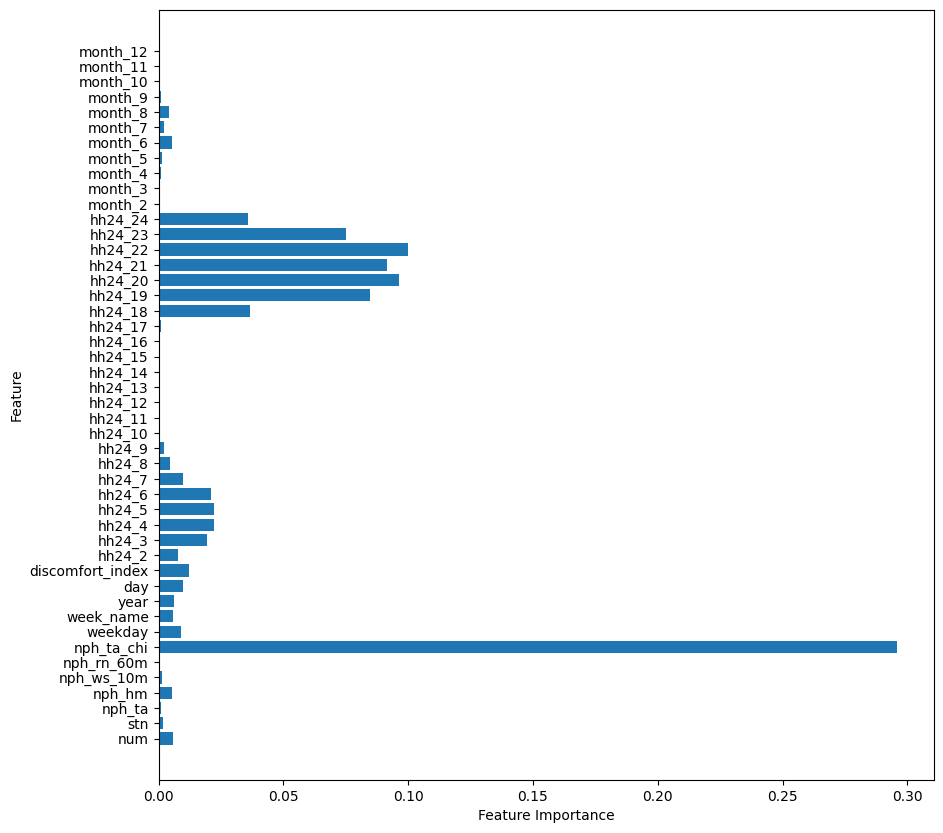

In [ ]:
# 특성 중요도를 시각화
feature_importances = model.feature_importances_

plt.figure(figsize=(10, 10))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

## XGBRegressor

In [ ]:
xgb_model = XGBRegressor(n_jobs=-1)
xgb_model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
## 성능 평가
pred = xgb_model.predict(x_test)

In [ ]:
print('mse :', mean_squared_error(y_test, pred))
print('mae :', mean_absolute_error(y_test, pred))
print('mape :', mean_absolute_percentage_error(y_test, pred))
print('r2 :', r2_score(y_test, pred))

mse : 28.17212890840436
mae : 3.756756196780508
mape : 0.03710685728947736
r2 : 0.9554432798336323


## LGBMRegressor

In [ ]:
lgb_model = LGBMRegressor(n_jobs=-1, verbose=-1)
lgb_model.fit(x_train,y_train)

LGBMRegressor(n_jobs=-1, verbose=-1)

In [ ]:
## 성능 평가
pred = lgb_model.predict(x_test)

In [ ]:
print('mse :', mean_squared_error(y_test, pred))
print('mae :', mean_absolute_error(y_test, pred))
print('mape :', mean_absolute_percentage_error(y_test, pred))
print('r2 :', r2_score(y_test, pred))

mse : 35.27192798876929
mae : 4.251261681070275
mape : 0.04197655574533508
r2 : 0.9442143179795325


## GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr_model = GradientBoostingRegressor()
gbr_model.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
## 성능 평가
pred = gbr_model.predict(x_test)

In [ ]:
print('mse :', mean_squared_error(y_test, pred))
print('mae :', mean_absolute_error(y_test, pred))
print('mape :', mean_absolute_percentage_error(y_test, pred))
print('r2 :', r2_score(y_test, pred))

## SVR

In [ ]:
## 성능 평가
pred = svr_model.predict(x_test)

In [ ]:
print('mse :', mean_squared_error(y_test, pred))
print('mae :', mean_absolute_error(y_test, pred))
print('mape :', mean_absolute_percentage_error(y_test, pred))
print('r2 :', r2_score(y_test, pred))

## catboost

In [10]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 22.2 MB/s eta 0:00:00


In [12]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor()
cat_model.fit(x_train,y_train)

Learning rate set to 0.162172
0:	learn: 22.7108518	total: 301ms	remaining: 5m
1:	learn: 20.8349587	total: 494ms	remaining: 4m 6s
2:	learn: 19.3801610	total: 693ms	remaining: 3m 50s
3:	learn: 18.0747524	total: 898ms	remaining: 3m 43s
4:	learn: 17.0402206	total: 1.12s	remaining: 3m 42s
5:	learn: 16.0172961	total: 1.34s	remaining: 3m 42s
6:	learn: 15.2652381	total: 1.56s	remaining: 3m 42s
7:	learn: 14.5380485	total: 1.77s	remaining: 3m 39s
8:	learn: 13.9106438	total: 1.98s	remaining: 3m 38s
9:	learn: 13.3731307	total: 2.18s	remaining: 3m 35s
10:	learn: 12.8534984	total: 2.37s	remaining: 3m 33s
11:	learn: 12.4124727	total: 2.56s	remaining: 3m 30s
12:	learn: 12.0276841	total: 2.78s	remaining: 3m 30s
13:	learn: 11.6869868	total: 2.97s	remaining: 3m 29s
14:	learn: 11.3287254	total: 3.19s	remaining: 3m 29s
15:	learn: 11.0382112	total: 3.44s	remaining: 3m 31s
16:	learn: 10.7778024	total: 3.63s	remaining: 3m 30s
17:	learn: 10.5240476	total: 3.8s	remaining: 3m 27s
18:	learn: 10.3113130	total: 3.9

In [15]:
pred = cat_model.predict(x_test)

In [16]:
print('mse :', mean_squared_error(y_test, pred))
print('mae :', mean_absolute_error(y_test, pred))
print('mape :', mean_absolute_percentage_error(y_test, pred))
print('r2 :', r2_score(y_test, pred))

mse : 19.933988825340553
mae : 3.1722017359769312
mape : 0.03141294634922378
r2 : 0.9684726289313111


In [11]:
!pip install optuna
import optuna
from catboost import CatBoostRegressor

In [ ]:
# Optuna를 사용한 CatBoost 회귀 모델 튜닝 함수 정의
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 4, 16),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-1, 10),
        'loss_function': 'RMSE',  # 회귀 문제에서는 RMSE 손실 함수를 사용
        'random_seed': 42,
        'verbose': False
    }

    model = CatBoostRegressor(**params)
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)], early_stopping_rounds=50, verbose=False)

    # 검증 데이터에 대한 예측값 계산
    y_pred = model.predict(x_test)

    # RMSE 계산
    r2 = r2_score(y_pred,y_test)

    return r2

# Optuna를 통한 하이퍼파라미터 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 최적화된 결과 출력
print('Best trial:')
trial = study.best_trial
print(f'  R2: {trial.value:.4f}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-06-16 15:33:34,748] A new study created in memory with name: no-name-08a6b75d-bde2-4129-b172-6d91d9d8359d
[I 2024-06-16 15:36:29,495] Trial 0 finished with value: 0.9688719468172222 and parameters: {'iterations': 747, 'learning_rate': 0.11742560373530743, 'depth': 8, 'l2_leaf_reg': 0.3141543887310833}. Best is trial 0 with value: 0.9688719468172222.
[I 2024-06-16 15:43:07,615] Trial 1 finished with value: 0.9624681291343714 and parameters: {'iterations': 622, 'learning_rate': 0.02793680314323576, 'depth': 13, 'l2_leaf_reg': 2.7030345559822058}. Best is trial 0 with value: 0.9688719468172222.
[I 2024-06-16 15:57:43,532] Trial 2 finished with value: 0.9729194300125402 and parameters: {'iterations': 613, 'learning_rate': 0.03552421280849678, 'depth': 16, 'l2_leaf_reg': 9.272094058285818}. Best is trial 2 with value: 0.9729194300125402.
[I 2024-06-16 15:59:02,601] Trial 3 finished with value: 0.9329790084496203 and parameters: {'iterations': 418, 'learning_rate': 0.0486705576543466